## **Домашнее задание № 1**

**Горская Елена**

Небольшие пояснения к ноутбуку:

1. Дерево, для которого исполняется алгоритм:
* можно случайно сгенерировать, запустив следующие несколько ячеек с генерацией.
* можно выбрать и загрузить файл в виде GraphML в соответствующей ячейке. В зависимости от наличия/отсутствия файла будет уже производиться парсинг. Любой из 2 вариантов работает.

2. Алгоритм, который тут реализован:
* Вначале это традиционный алгоритм Right-Heavy-HV-Tree-Draw (который описан в книжке)
* Дальше идёт пара небольших экспериментов: в первом просто чередую "вертикальную" и "горизонтальную" комбинации, а во втором смотрю на максимальные $x$ и $y$ координаты и использую "горизонтальную" комбинацию, если модуль $y$ больше, и "вертикальную" в противном случае.

3. Здесь можно взять несколько готовых примеров бинарных деревьев для тестирования: https://drive.google.com/drive/folders/1m8vqm7fLuKzezCMeqDDSvf_2rOMSZY1c?usp=sharing

In [1]:
# библиотеки
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
import random

from google.colab import files

import xml.etree.ElementTree as ET

В следующей ячейке генерируется бинарное дерево.

In [2]:
edges = []
nodes = []
root = "v"

# чтобы дерево все же не продолжалось бесконечно
down_factor = 0.95
depth_factor = 8

def create_children(v, p):
  global edges
  global nodes

  new_p = p * down_factor
  if len(v) >= depth_factor:
    new_p /= 2
  # добавляем обоих детей
  if (random.random() <= 0.5 * p):
    nodes.append(v + "l")
    edges.append([v + "l", v + "r"])
    create_children(v + "l", new_p)
    nodes.append(v + "r")
    create_children(v + "r", new_p)
  # добавляем только левого
  else:
    if (random.random() <= p):
      nodes.append(v + "l")
      edges.append([v + "l"])
      create_children(v + "l", new_p)

    else:
      edges.append([])

def generate_tree(p):
  global nodes
  global edges
  nodes.append("v")
  create_children("v", p)


# собственно, генерация
generate_tree(0.75)

Желательно проверить число вершин, потому что засчет случайности (теоретически) может и всего 1 вершина сгенерироваться. Но и больше 40-50 вершин - это тоже не очень хорошо, так как на рисунке видно будет плохо. Поэтому на всякий случай в цикле ниже своего рода "перестраховка".

In [3]:
while(len(nodes) < 5 or len(nodes) > 50):
  edges = []
  nodes = []
  generate_tree(0.75)

print(len(nodes))

27


In [4]:
# это для проверки, был ли загружен файл
uploaded = "nothing"

In [5]:
# При желании, можно загрузить произвольное ДВОИЧНОЕ дерево в формате GraphML.
# Ссылка на примеры есть в начале ноутбука
uploaded = files.upload()

Saving tree-example-0.xml to tree-example-0.xml


In [6]:
# парсинг файла

node_val = "{http://graphml.graphdrawing.org/xmlns}node"
edge_val = "{http://graphml.graphdrawing.org/xmlns}edge"

def parse_graph(xml_file):
  root = ET.fromstring(xml_file)
  nodes = []
  edges = []

  # чтобы вычислить корень
  edges_into = []
  # g - это как раз граф в разметке GraphMl
  g = root[0]

  # ребра храним как список: i-й элемент массива - это список номеров вершин,
  # в которые идут ребра из вершины i
  for node in g.findall(node_val):
    nodes.append(node.get("id"))
  for _ in range(len(nodes)):
    edges.append([])
    edges_into.append([])
  for edge in g.findall(edge_val):
    # номер исходной вершины
    s = nodes.index(edge.get("source"))
    edges[s].append(edge.get("target"))

    t = nodes.index(edge.get("target"))
    edges_into[t].append(edge.get("source"))
  
  root = ""
  for i in range(len(edges_into)):
    if len(edges_into[i]) == 0:
      root = nodes[i]
      break
  return nodes, edges, root

In [7]:
if (uploaded != "nothing"):
  mykey = list(uploaded.keys())[0]
  graphML = uploaded[mykey]
  nodes, edges, root = parse_graph(graphML)

# иначе используем сгенерированное дерево

**Алгоритм Right-heavy-HV-tree-draw**

In [8]:
# x, y координаты каждой вершины
hv_coords = np.zeros((len(nodes), 2))

# обновляет координаты вершин, возвращает самую правую x-координату поддерева
def do_hv(v, x, y):
  v_idx = nodes.index(v)
  edge = edges[v_idx]
  max_x = x
  hv_coords[v_idx] = [x, y]
  # левое поддерево
  if len(edge) > 0:
    max_x = do_hv(edge[0], x, y - 1)
  
  # правое поддерево
  if len(edge) > 1:
    max_x = do_hv(edge[1], max_x + 1, y)
  
  return max_x

# испоняем алгоритм
do_hv(root, 0, 0)

13

Рисуем:

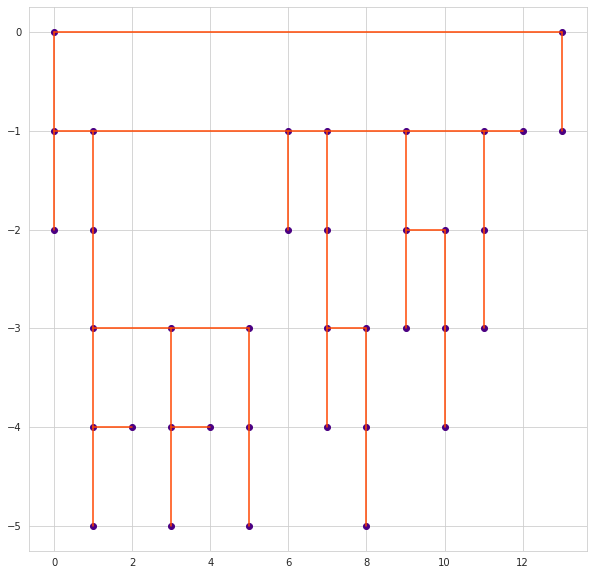

In [9]:
sns.set_style("whitegrid")

plt.figure(figsize=(10, 10))
plt.scatter(hv_coords[:, 0], hv_coords[:, 1], c='indigo', marker='o')
for i in range(len(edges)):
  for v in edges[i]:
    trg_idx = nodes.index(v)
    plt.plot([hv_coords[i][0], hv_coords[trg_idx][0]], 
            [hv_coords[i][1], hv_coords[trg_idx][1]], color = 'orangered')

plt.show()

Чтобы выглядело привычнее, можем повернуть:

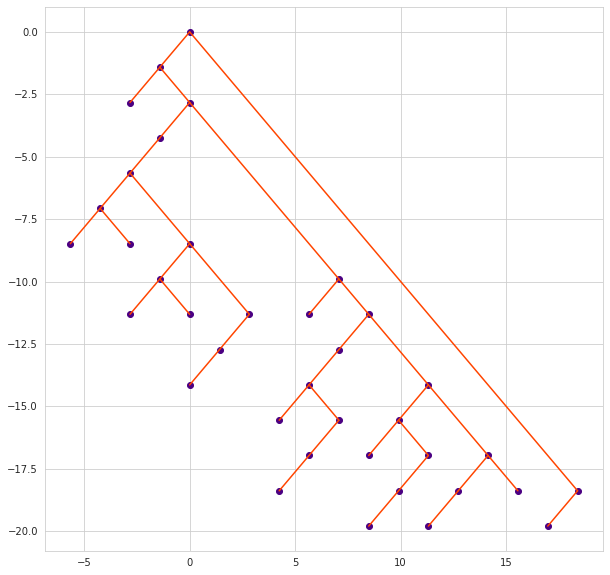

In [10]:
turned_coords = []
sq = math.sqrt(2)

for v in hv_coords:
  turned_coords.append([(sq * v[0] + v[1] * sq), -v[0] * sq + v[1] * sq])

turned_coords = np.array(turned_coords)

plt.figure(figsize=(10, 10))
plt.scatter(turned_coords[:, 0], turned_coords[:, 1], c='indigo', marker='o')
for i in range(len(edges)):
  for v in edges[i]:
    trg_idx = nodes.index(v)
    plt.plot([turned_coords[i][0], turned_coords[trg_idx][0]], 
            [turned_coords[i][1], turned_coords[trg_idx][1]], color = 'orangered')

plt.show()

Основной алгоритм на этом заканчивается, теперь немного экспериментов. Ограничения по ширине и высоте вписывать не буду, поскольку в начале ноутбука может быть использована генерация случайного графа, так что это может быть некорректно.

Пробую дальше такие два подхода:

1) По очереди идем по горизонтали и по вертикали.

2) Идем в зависимости от координаты: если $|x| \leq |y|$, то вправо, а иначе - вниз.

**Алгоритм 1: ходим по очереди**

In [11]:
# x, y координаты каждой вершины
hv_coords_change = np.zeros((len(nodes), 2))

# 1 - вправо, -1 - вниз

# обновляет координаты вершин, возвращает самую правую x-координату поддерева
def do_hv_change(v, x, y, turn):
  v_idx = nodes.index(v)
  edge = edges[v_idx]
  max_x = x
  max_y = y
  hv_coords_change[v_idx] = [x, y]
  if (turn == 1):
    # левое поддерево
    if len(edge) > 0:
      cur_x, cur_y = do_hv_change(edge[0], x, y - 1, -1)
      max_x = max(max_x, cur_x)
      max_y = min(max_y, cur_y)
  
    # правое поддерево
    if len(edge) > 1:
      cur_x, cur_y = do_hv_change(edge[1], max_x + 1, y, -1)
      max_x = max(max_x, cur_x)
      max_y = min(max_y, cur_y)

  else:
    # правое поддерево
    if len(edge) > 0:
      cur_x, cur_y = do_hv_change(edge[0], x + 1, y, 1)
      max_x = max(max_x, cur_x)
      max_y = min(max_y, cur_y)

    # левое поддерево
    if len(edge) > 1:
      cur_x, cur_y = do_hv_change(edge[1], x, max_y - 1, 1)
      max_x = max(max_x, cur_x)
      max_y = min(max_y, cur_y)
  
  return max_x, max_y

# выполняем алгоритм
do_hv_change(root, 0, 0, 1)

(15, -6)

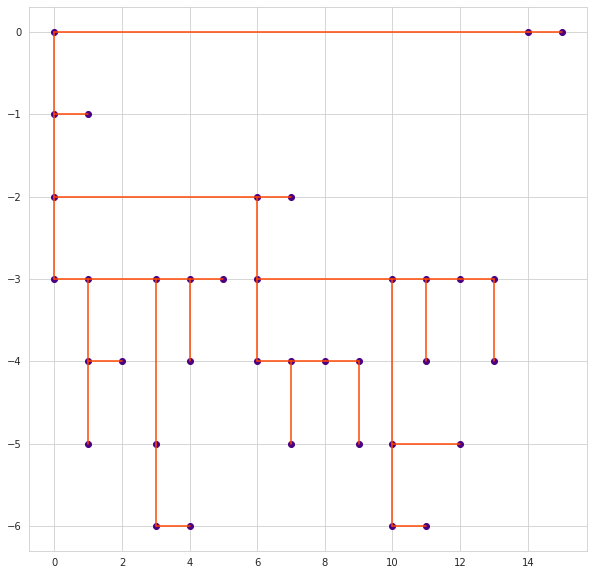

In [12]:
plt.figure(figsize=(10, 10))
plt.scatter(hv_coords_change[:, 0], hv_coords_change[:, 1], c='indigo', marker='o')
for i in range(len(edges)):
  for v in edges[i]:
    trg_idx = nodes.index(v)
    plt.plot([hv_coords_change[i][0], hv_coords_change[trg_idx][0]], 
            [hv_coords_change[i][1], hv_coords_change[trg_idx][1]], color = 'orangered')

plt.show()

**Алгоритм 2: с учетом координат**

In [13]:
# x, y координаты каждой вершины
hv_coords_max = np.zeros((len(nodes), 2))

# обновляет координаты вершин, возвращает самую правую x-координату поддерева
def do_hv_max(v, x, y):
  v_idx = nodes.index(v)
  edge = edges[v_idx]
  max_x = x
  max_y = y
  hv_coords_max[v_idx] = [x, y]
  if (max_x <= -max_y):
    # левое поддерево
    if len(edge) > 0:
      cur_x, cur_y = do_hv_max(edge[0], x, y - 1)
      max_x = max(max_x, cur_x)
      max_y = min(max_y, cur_y)
  
    # правое поддерево
    if len(edge) > 1:
      cur_x, cur_y = do_hv_max(edge[1], max_x + 1, y)
      max_x = max(max_x, cur_x)
      max_y = min(max_y, cur_y)
  else:
    # правое поддерево
    if len(edge) > 0:
      cur_x, cur_y = do_hv_max(edge[0], x + 1, y)
      max_x = max(max_x, cur_x)
      max_y = min(max_y, cur_y)

    # левое поддерево
    if len(edge) > 1:
      cur_x, cur_y = do_hv_max(edge[1], x, max_y - 1)
      max_x = max(max_x, cur_x)
      max_y = min(max_y, cur_y)
  
  return max_x, max_y

# сам алгоритм
do_hv_max(root, 0, 0)

(14, -7)

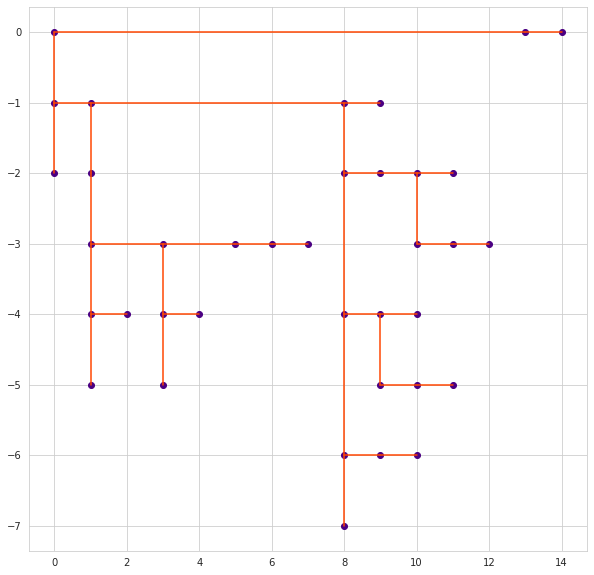

In [14]:
plt.figure(figsize=(10, 10))
plt.scatter(hv_coords_max[:, 0], hv_coords_max[:, 1], c='indigo', marker='o')
for i in range(len(edges)):
  for v in edges[i]:
    trg_idx = nodes.index(v)
    plt.plot([hv_coords_max[i][0], hv_coords_max[trg_idx][0]], 
            [hv_coords_max[i][1], hv_coords_max[trg_idx][1]], color = 'orangered')

plt.show()

В целом, самый первый алгоритм (из книжки, классический) - самый надежный и визуально наиболее понятный. Но и у остальных 2 алгоритмов картинки получились интересные.